In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import numpy as np

In [3]:
# Load the webscraped gas prices database
gas_df = pd.read_csv('../data/gas_prices.csv')
gas_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.258,1.335,1.324,NaN
1,1991,NaN,1.094,1.040,1.076,1.126,1.128,1.096,1.115,1.109,1.088,1.099,1.076
2,1992,1.022,1.006,1.013,1.052,1.107,1.145,1.137,1.122,1.122,1.114,1.111,1.078
3,1993,1.062,1.054,1.052,1.078,1.100,1.097,1.078,1.062,1.050,1.092,1.066,1.014
4,1994,0.998,1.009,1.008,1.027,1.047,1.078,1.106,1.155,1.144,1.114,1.116,1.091


In [4]:
# fill Dec 1990 and Jan 1991 with the average of surrounding values
gas_df.loc[0,'Dec'] = np.round((gas_df.loc[0,'Oct'] + gas_df.loc[0,'Nov'] + gas_df.loc[1, 'Feb'])/3, 3)
gas_df.loc[1,'Jan'] = np.round((gas_df.loc[0,'Nov'] + gas_df.loc[1,'Feb'] + gas_df.loc[1, 'Mar'])/3, 3)

print(gas_df.head())

   Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
0  1990    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  1.258  1.335   
1  1991  1.153  1.094  1.040  1.076  1.126  1.128  1.096  1.115  1.109  1.088   
2  1992  1.022  1.006  1.013  1.052  1.107  1.145  1.137  1.122  1.122  1.114   
3  1993  1.062  1.054  1.052  1.078  1.100  1.097  1.078  1.062  1.050  1.092   
4  1994  0.998  1.009  1.008  1.027  1.047  1.078  1.106  1.155  1.144  1.114   

     Nov    Dec  
0  1.324  1.251  
1  1.099  1.076  
2  1.111  1.078  
3  1.066  1.014  
4  1.116  1.091  


In [5]:
# turn this data frame in to a time series with year and month as the index
# Melt the DataFrame
df_melted = gas_df.melt(id_vars=['Year'], var_name='Month', value_name='Price')

# Create a 'Date' column
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + df_melted['Month'], format='%Y%b')

# Drop redundant columns
gas_df_ts = df_melted.drop(['Year', 'Month'], axis=1)

# Sort the DataFrame
gas_df_ts = gas_df_ts.sort_values('Date')

# drop nans
gas_df_ts = gas_df_ts.dropna()

# set the index to the date
gas_df_ts = gas_df_ts.set_index('Date')

# Display the transformed DataFrame
print(gas_df_ts.head())
print(gas_df_ts.tail())

            Price
Date             
1990-09-01  1.258
1990-10-01  1.335
1990-11-01  1.324
1990-12-01  1.251
1991-01-01  1.153
            Price
Date             
2023-06-01  3.571
2023-07-01  3.597
2023-08-01  3.840
2023-09-01  3.836
2023-10-01  3.613


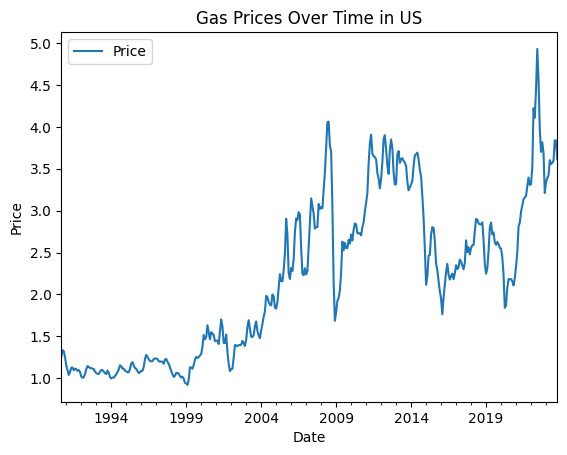

In [6]:
# plot the data with title and axis labels
gas_df_ts.plot()
plt.title('Gas Prices Over Time in US')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [7]:
# Connect to the database
conn = sqlite3.connect('../food_inflation_analysis.db')
# load the food inflation data
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
cpi_food_data.index = pd.to_datetime(cpi_food_data['Date'])
cpi_food_data = cpi_food_data.drop('Date', axis=1)
# Close the connection
conn.close()

In [15]:
# get the inflation data for the same time period as the gas prices
cpi_food_data = cpi_food_data[cpi_food_data.index >= gas_df_ts.index.min()]
gas_price_data = gas_df_ts[gas_df_ts.index <= cpi_food_data.index.max()]

# get the correlation between the two data sets
corr = gas_price_data['Price'].corr(cpi_food_data['CPI'])
print('Correlation between gas prices and food inflation: ', corr)

lag = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
corrs = []
confidences = []
for i in lag:
    corr = gas_price_data['Price'].shift(i).corr(cpi_food_data['CPI'])
    print(f'Correlation between gas prices and food inflation with lag {i}: ', corr)
    corrs.append(corr)
    # get the number of observations
    n = len(gas_price_data['Price'].shift(i))

    # get the t critical value
    t_crit = stats.t.ppf(0.975, n-2)

    # get the standard error
    se = np.sqrt((1-corr**2)/(n-2))

    # get the margin of error
    moe = t_crit*se

    # get the confidence interval
    ci = (corr-moe, corr+moe)
    confidences.append(ci)
    # print('Confidence interval for the correlation: ', ci)
    

Correlation between gas prices and food inflation:  0.26535412189536334
Correlation between gas prices and food inflation with lag 1:  0.28186111633521965
Correlation between gas prices and food inflation with lag 2:  0.2975514444644492
Correlation between gas prices and food inflation with lag 3:  0.3092783790516434
Correlation between gas prices and food inflation with lag 4:  0.3166294195887912
Correlation between gas prices and food inflation with lag 5:  0.3164122561054721
Correlation between gas prices and food inflation with lag 6:  0.3074628465516054
Correlation between gas prices and food inflation with lag 7:  0.2920212881330488
Correlation between gas prices and food inflation with lag 8:  0.2732847233979759
Correlation between gas prices and food inflation with lag 9:  0.2496891063518472
Correlation between gas prices and food inflation with lag 10:  0.22113738680207182
Correlation between gas prices and food inflation with lag 11:  0.1893374108185178
Correlation between ga

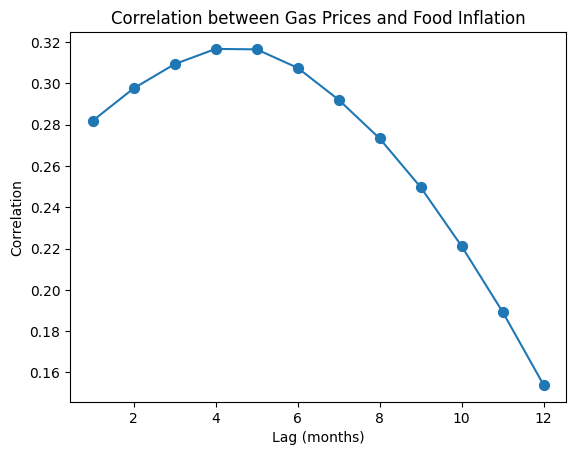

In [19]:
# plot the correlation vs lag
plt.plot(lag, corrs)
plt.scatter(lag, corrs, s=50)
plt.title('Correlation between Gas Prices and Food Inflation')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.show()

In [79]:
# Create a dataframe with lagged values 1-6
gas_price_data_lagged = pd.DataFrame()
gas_price_data_lagged['fuel_price'] = gas_price_data['Price']
for i in range(1,7):
    gas_price_data_lagged[f'fuel_price_lag_{i}'] = gas_price_data['Price'].shift(i)

# print
print(gas_price_data_lagged.head(8))

            Price_lag_1  Price_lag_2  Price_lag_3  Price_lag_4  Price_lag_5  \
Date                                                                          
1990-09-01          NaN          NaN          NaN          NaN          NaN   
1990-10-01        1.258          NaN          NaN          NaN          NaN   
1990-11-01        1.335        1.258          NaN          NaN          NaN   
1990-12-01        1.324        1.335        1.258          NaN          NaN   
1991-01-01        1.251        1.324        1.335        1.258          NaN   
1991-02-01        1.153        1.251        1.324        1.335        1.258   
1991-03-01        1.094        1.153        1.251        1.324        1.335   
1991-04-01        1.040        1.094        1.153        1.251        1.324   

            Price_lag_6  
Date                     
1990-09-01          NaN  
1990-10-01          NaN  
1990-11-01          NaN  
1990-12-01          NaN  
1991-01-01          NaN  
1991-02-01          NaN  
1

In [81]:
# save the lagged data to database
conn = sqlite3.connect('../food_inflation_analysis.db')
gas_price_data_lagged.to_sql('gas_prices', conn, if_exists='replace')
# get a list of all the tables
c = conn.cursor()
c.execute('''SELECT name FROM sqlite_master WHERE type='table';''')
print(c.fetchall())
conn.close()

[('DOW_JONES_REAL',), ('USA_MEAT_EXPORT_IMPORT',), ('interest_rate',), ('food_production',), ('OCED_USA_FOOD_INFLATION',), ('gas_prices',)]
